In [1]:
%cd ..

/home/wu/repo/gesture-wgan


In [2]:
import datasets
import models
from tools.config import JsonConfig
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

# Experiment under cl34, for continuity loss 1 and 0, 0.5
cl0_hparams_path = "hparams/wgan/closs-hip/cl34-closs0-hip.json"
cl0_chkpt_path = "results/log_20210805_1943/chkpt/generator_232k.pt"
cl1_hparams_path = "hparams/wgan/closs-hip/cl34-closs1-hip.json"
cl1_chkpt_path = "results/log_20210805_1944/chkpt/generator_232k.pt"
cl05_hparams_path = "hparams/wgan/closs-hip/cl34-closs05-hip.json"
cl05_chkpt_path = "results/log_20210810_1503/chkpt/generator_232k.pt"
cl01_hparams_path = "hparams/wgan/closs-hip/cl34-closs01-hip.json"
cl01_chkpt_path = "results/log_20210810_2027/chkpt/generator_232k.pt"
cl2_hparams_path = "hparams/wgan/closs-hip/cl34-closs2-hip.json"
cl2_chkpt_path = "results/log_20210811_1535/chkpt/generator_232k.pt"


DATASET_NAME = "takekuchi"
MODEL_NAME = "wgan"

cl0_hparams = JsonConfig(cl0_hparams_path)
cl1_hparams = JsonConfig(cl1_hparams_path)
cl05_hparams = JsonConfig(cl05_hparams_path)
cl01_hparams = JsonConfig(cl01_hparams_path)
cl2_hparams = JsonConfig(cl2_hparams_path)

dataset_class = datasets.dataset_dict[DATASET_NAME]
model_class = models.model_dict[MODEL_NAME]

data = dataset_class(cl0_hparams, is_training=False)
speech_dim, motion_dim = data.get_dims()

cl0_model = model_class(speech_dim, motion_dim, cl0_hparams)
cl0_model.build(chkpt_path=cl0_chkpt_path)
cl1_model = model_class(speech_dim, motion_dim, cl1_hparams)
cl1_model.build(chkpt_path=cl1_chkpt_path)
cl05_model = model_class(speech_dim, motion_dim, cl05_hparams)
cl05_model.build(chkpt_path=cl05_chkpt_path)
cl01_model = model_class(speech_dim, motion_dim, cl01_hparams)
cl01_model.build(chkpt_path=cl01_chkpt_path)
cl2_model = model_class(speech_dim, motion_dim, cl2_hparams)
cl2_model.build(chkpt_path=cl2_chkpt_path)

In [3]:
# Generate motion using models

def generate_motion_on_test(model, data):
    output_list, motion_list = model.synthesize_batch(data.get_test_dataset())
    output_list_numpy, motion_list_numpy = [], []
    for output, motion in zip(output_list, motion_list):
        output_list_numpy.append(data.motion_scaler.inverse_transform(output.cpu().numpy()))
        motion_list_numpy.append(data.motion_scaler.inverse_transform(motion.cpu().numpy()))
    return output_list_numpy, motion_list_numpy

cl0_output_list, motion_list = generate_motion_on_test(cl0_model, data)
cl1_output_list, _ = generate_motion_on_test(cl1_model, data)
cl05_output_list, _ = generate_motion_on_test(cl05_model, data)
cl01_output_list, _ = generate_motion_on_test(cl01_model, data)
cl2_output_list, _ = generate_motion_on_test(cl2_model, data)

In [4]:
# Calculate position of every joint

from tools.rot_to_pos import rot2pos

motion_list = [rot2pos(x) for x in motion_list]
cl0_output_list = [rot2pos(x) for x in cl0_output_list]
cl1_output_list = [rot2pos(x) for x in cl1_output_list]
cl05_output_list = [rot2pos(x) for x in cl05_output_list]
cl01_output_list = [rot2pos(x) for x in cl01_output_list]
cl2_output_list = [rot2pos(x) for x in cl2_output_list]

In [7]:
# Calculate position KDE

import numpy as np
from models.wgan.kde_score import calculate_kde

# Concat all motions
motion_cat = np.concatenate(motion_list, axis=0)
cl0_output_cat = np.concatenate(cl0_output_list, axis=0)
cl01_output_cat = np.concatenate(cl01_output_list, axis=0)
cl05_output_cat = np.concatenate(cl05_output_list, axis=0)
cl1_output_cat = np.concatenate(cl1_output_list, axis=0)
cl2_output_cat = np.concatenate(cl2_output_list, axis=0)


gt_kde_mean, gt_kde_std, gt_kde_se = calculate_kde(motion_cat, motion_cat)
cl0_kde_mean, cl0_kde_std, cl0_kde_se = calculate_kde(cl0_output_cat, motion_cat)
cl01_kde_mean, cl01_kde_std, cl01_kde_se = calculate_kde(cl01_output_cat, motion_cat)
cl05_kde_mean, cl05_kde_std, cl05_kde_se = calculate_kde(cl05_output_cat, motion_cat)
cl1_kde_mean, cl1_kde_std, cl1_kde_se = calculate_kde(cl1_output_cat, motion_cat)
cl2_kde_mean, cl2_kde_std, cl2_kde_se = calculate_kde(cl2_output_cat, motion_cat)

print("gt mean: {}, std: {}, se: {}".format(gt_kde_mean, gt_kde_std, gt_kde_se))
print("cl0 mean: {}, std: {}, se: {}".format(cl0_kde_mean, cl0_kde_std, cl0_kde_se))
print("cl01 mean: {}, std: {}, se: {}".format(cl01_kde_mean, cl01_kde_std, cl01_kde_se))
print("cl05 mean: {}, std: {}, se: {}".format(cl05_kde_mean, cl05_kde_std, cl05_kde_se))
print("cl1 mean: {}, std: {}, se: {}".format(cl1_kde_mean, cl1_kde_std, cl1_kde_se))
print("cl2 mean: {}, std: {}, se: {}".format(cl2_kde_mean, cl2_kde_std, cl2_kde_se))

gt mean: -28.220200620654385, std: 1.0241176546366044, se: 0.009711749218865879
cl0 mean: -49.74723432930574, std: 12.108132816464122, se: 0.11825340917330002
cl01 mean: -48.049783802803866, std: 10.70376453078298, se: 0.10453772401903401
cl05 mean: -48.59245250627422, std: 13.500506723495738, se: 0.13185195189216975
cl1 mean: -48.5580230377119, std: 21.102203049567898, se: 0.20609349843647762
cl2 mean: -48.81409937466677, std: 12.190509833741599, se: 0.11905793975437719


In [8]:
# Transform to velocity

import numpy as np

def calcualte_velocity(motion):
    '''(T, D)'''
    T = motion.shape[0]
    motion = motion.reshape(T, -1, 3)
    velocity = np.ndarray(shape=(0, motion.shape[1]))
    for t in range(1, T):
        vel = np.sqrt(np.sum((motion[t] - motion[t-1]) ** 2, axis=-1))
        velocity = np.append(velocity, vel[np.newaxis, :], axis=0)
    return velocity

motion_vel_list = [calcualte_velocity(x) for x in motion_list]
cl0_output_vel_list = [calcualte_velocity(x) for x in cl0_output_list]
cl1_output_vel_list = [calcualte_velocity(x) for x in cl1_output_list]
cl05_output_vel_list = [calcualte_velocity(x) for x in cl05_output_list]
cl01_output_vel_list = [calcualte_velocity(x) for x in cl01_output_list]
cl2_output_vel_list = [calcualte_velocity(x) for x in cl2_output_list]

In [9]:
# Concatenation
motion_vels = np.concatenate(motion_vel_list, axis=0).T
cl0_output_vels = np.concatenate(cl0_output_vel_list, axis=0).T
cl1_output_vels = np.concatenate(cl1_output_vel_list, axis=0).T
cl05_output_vels = np.concatenate(cl05_output_vel_list, axis=0).T
cl01_output_vels = np.concatenate(cl01_output_vel_list, axis=0).T
cl2_output_vels = np.concatenate(cl2_output_vel_list, axis=0).T

In [10]:
# Average velocity

motion_vel_avg = np.mean(motion_vels, axis=0)
cl0_output_vel_avg = np.mean(cl0_output_vels, axis=0)
cl1_output_vel_avg = np.mean(cl1_output_vels, axis=0)
cl05_output_vel_avg = np.mean(cl05_output_vels, axis=0)
cl01_output_vel_avg = np.mean(cl01_output_vels, axis=0)
cl2_output_vel_avg = np.mean(cl2_output_vels, axis=0)

In [11]:
# Calculate velocity KDE
from models.wgan.kde_score import calculate_kde

gt_kde_mean, gt_kde_std, gt_kde_se = calculate_kde(motion_vel_avg[:,None], motion_vel_avg[:,None])
cl0_kde_mean, cl0_kde_std, cl0_kde_se = calculate_kde(cl0_output_vel_avg[:,None], motion_vel_avg[:,None])
cl01_kde_mean, cl01_kde_std, cl01_kde_se = calculate_kde(cl01_output_vel_avg[:,None], motion_vel_avg[:,None])
cl05_kde_mean, cl05_kde_std, cl05_kde_se = calculate_kde(cl05_output_vel_avg[:,None], motion_vel_avg[:,None])
cl1_kde_mean, cl1_kde_std, cl1_kde_se = calculate_kde(cl1_output_vel_avg[:,None], motion_vel_avg[:,None])
cl2_kde_mean, cl2_kde_std, cl2_kde_se = calculate_kde(cl2_output_vel_avg[:,None], motion_vel_avg[:,None])

print("gt mean: {}, std: {}, se: {}".format(gt_kde_mean, gt_kde_std, gt_kde_se))
print("cl0 mean: {}, std: {}, se: {}".format(cl0_kde_mean, cl0_kde_std, cl0_kde_se))
print("cl01 mean: {}, std: {}, se: {}".format(cl01_kde_mean, cl01_kde_std, cl01_kde_se))
print("cl05 mean: {}, std: {}, se: {}".format(cl05_kde_mean, cl05_kde_std, cl05_kde_se))
print("cl1 mean: {}, std: {}, se: {}".format(cl1_kde_mean, cl1_kde_std, cl1_kde_se))
print("cl2 mean: {}, std: {}, se: {}".format(cl2_kde_mean, cl2_kde_std, cl2_kde_se))

gt mean: 0.6182473845533766, std: 0.5041489843387236, se: 0.0047901357220440305
cl0 mean: 0.4878772858438215, std: 0.49029843849165405, se: 0.004798322812083434
cl01 mean: 0.5972913614458243, std: 0.5478755152767181, se: 0.005361802887281665
cl05 mean: 0.5808493027973224, std: 0.5100007266782619, se: 0.004991139944332269
cl1 mean: 0.5823270024366084, std: 0.524110313723384, se: 0.005129223911305455
cl2 mean: 0.5855602887910231, std: 0.5494167211853122, se: 0.005376885952795957


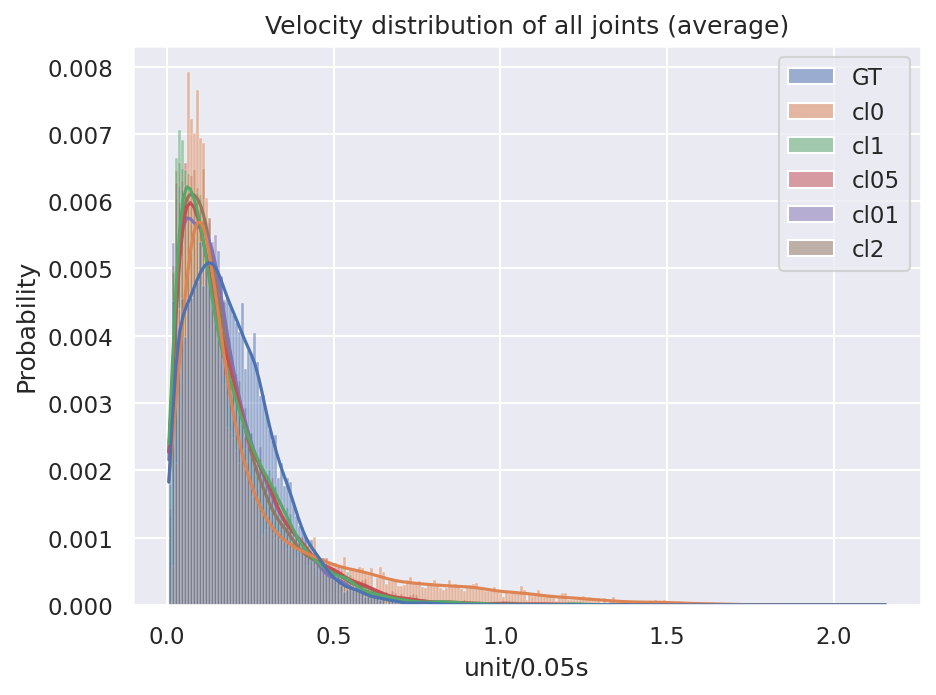

In [12]:
# Plot velocity distribution
fig = plt.figure(dpi=150)

sns.histplot(data={"GT": motion_vel_avg, "cl0": cl0_output_vel_avg, "cl1": cl1_output_vel_avg, "cl05": cl05_output_vel_avg, "cl01": cl01_output_vel_avg, "cl2": cl2_output_vel_avg},
    stat='probability', kde=True)

plt.title("Velocity distribution of all joints (average)")
plt.xlabel("unit/0.05s")
plt.tight_layout()
plt.show()

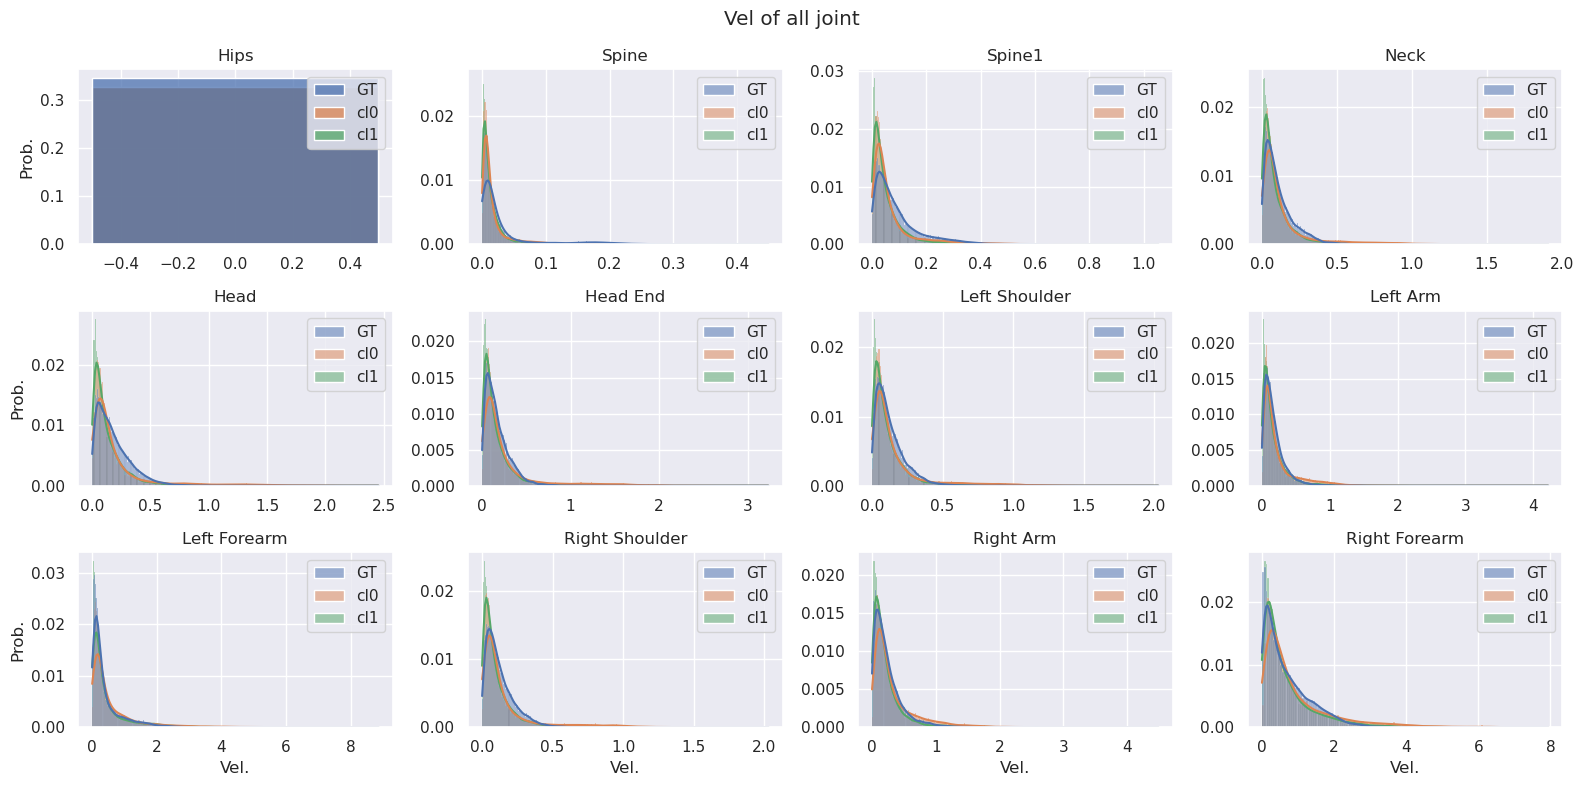

In [ ]:
fig, axes = plt.subplots(3, 4, sharex=False, figsize=(16,8))
fig.suptitle('Vel of all joint')

sns.histplot(ax=axes[0][0], data={"GT": motion_vels[0], "cl0": cl0_output_vels[0], "cl1": cl1_output_vels[0]}, stat='probability')
axes[0][0].set_title('Hips')
axes[0][0].set_xlabel('')
axes[0][0].set_ylabel('Prob.')

sns.histplot(ax=axes[0][1], data={"GT": motion_vels[1], "cl0": cl0_output_vels[1], "cl1": cl1_output_vels[1]}, stat='probability', kde=True)
axes[0][1].set_title('Spine')
axes[0][1].set_xlabel('')
axes[0][1].set_ylabel('')

sns.histplot(ax=axes[0][2], data={"GT": motion_vels[2], "cl0": cl0_output_vels[2], "cl1": cl1_output_vels[2]}, stat='probability', kde=True)
axes[0][2].set_title('Spine1')
axes[0][2].set_xlabel('')
axes[0][2].set_ylabel('')

sns.histplot(ax=axes[0][3], data={"GT": motion_vels[3], "cl0": cl0_output_vels[3], "cl1": cl1_output_vels[3]}, stat='probability', kde=True)
axes[0][3].set_title('Neck')
axes[0][3].set_xlabel('')
axes[0][3].set_ylabel('')

sns.histplot(ax=axes[1][0], data={"GT": motion_vels[4], "cl0": cl0_output_vels[4], "cl1": cl1_output_vels[4]}, stat='probability', kde=True)
axes[1][0].set_title('Head')
axes[1][0].set_xlabel('')
axes[1][0].set_ylabel('Prob.')

sns.histplot(ax=axes[1][1], data={"GT": motion_vels[5], "cl0": cl0_output_vels[5], "cl1": cl1_output_vels[5]}, stat='probability', kde=True)
axes[1][1].set_title('Head End')
axes[1][1].set_xlabel('')
axes[1][1].set_ylabel('')

sns.histplot(ax=axes[1][2], data={"GT": motion_vels[6], "cl0": cl0_output_vels[6], "cl1": cl1_output_vels[6]}, stat='probability', kde=True)
axes[1][2].set_title('Left Shoulder')
axes[1][2].set_xlabel('')
axes[1][2].set_ylabel('')

sns.histplot(ax=axes[1][3], data={"GT": motion_vels[7], "cl0": cl0_output_vels[7], "cl1": cl1_output_vels[7]}, stat='probability', kde=True)
axes[1][3].set_title('Left Arm')
axes[1][3].set_xlabel('')
axes[1][3].set_ylabel('')

sns.histplot(ax=axes[2][0], data={"GT": motion_vels[8], "cl0": cl0_output_vels[8], "cl1": cl1_output_vels[8]}, stat='probability', kde=True)
axes[2][0].set_title('Left Forearm')
axes[2][0].set_xlabel('Vel.')
axes[2][0].set_ylabel('Prob.')

sns.histplot(ax=axes[2][1], data={"GT": motion_vels[9], "cl0": cl0_output_vels[9], "cl1": cl1_output_vels[9]}, stat='probability', kde=True)
axes[2][1].set_title('Right Shoulder')
axes[2][1].set_xlabel('Vel.')
axes[2][1].set_ylabel('')

sns.histplot(ax=axes[2][2], data={"GT": motion_vels[10], "cl0": cl0_output_vels[10], "cl1": cl1_output_vels[10]}, stat='probability', kde=True)
axes[2][2].set_title('Right Arm')
axes[2][2].set_xlabel('Vel.')
axes[2][2].set_ylabel('')

sns.histplot(ax=axes[2][3], data={"GT": motion_vels[11], "cl0": cl0_output_vels[11], "cl1": cl1_output_vels[11]}, stat='probability', kde=True)
axes[2][3].set_title('Right Forearm')
axes[2][3].set_xlabel('Vel.')
axes[2][3].set_ylabel('')

plt.tight_layout()
plt.show()

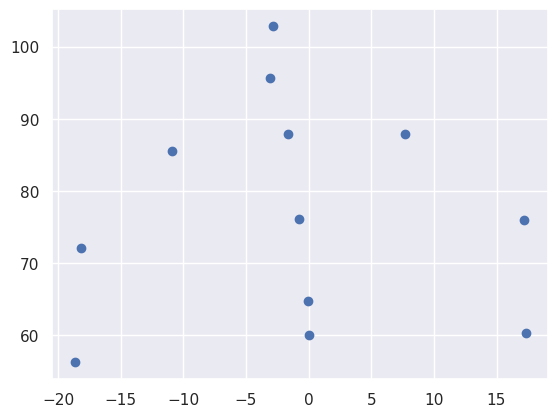

In [ ]:
plt.scatter(motion_list[0][0][::3], motion_list[0][0][1::3])
plt.show()

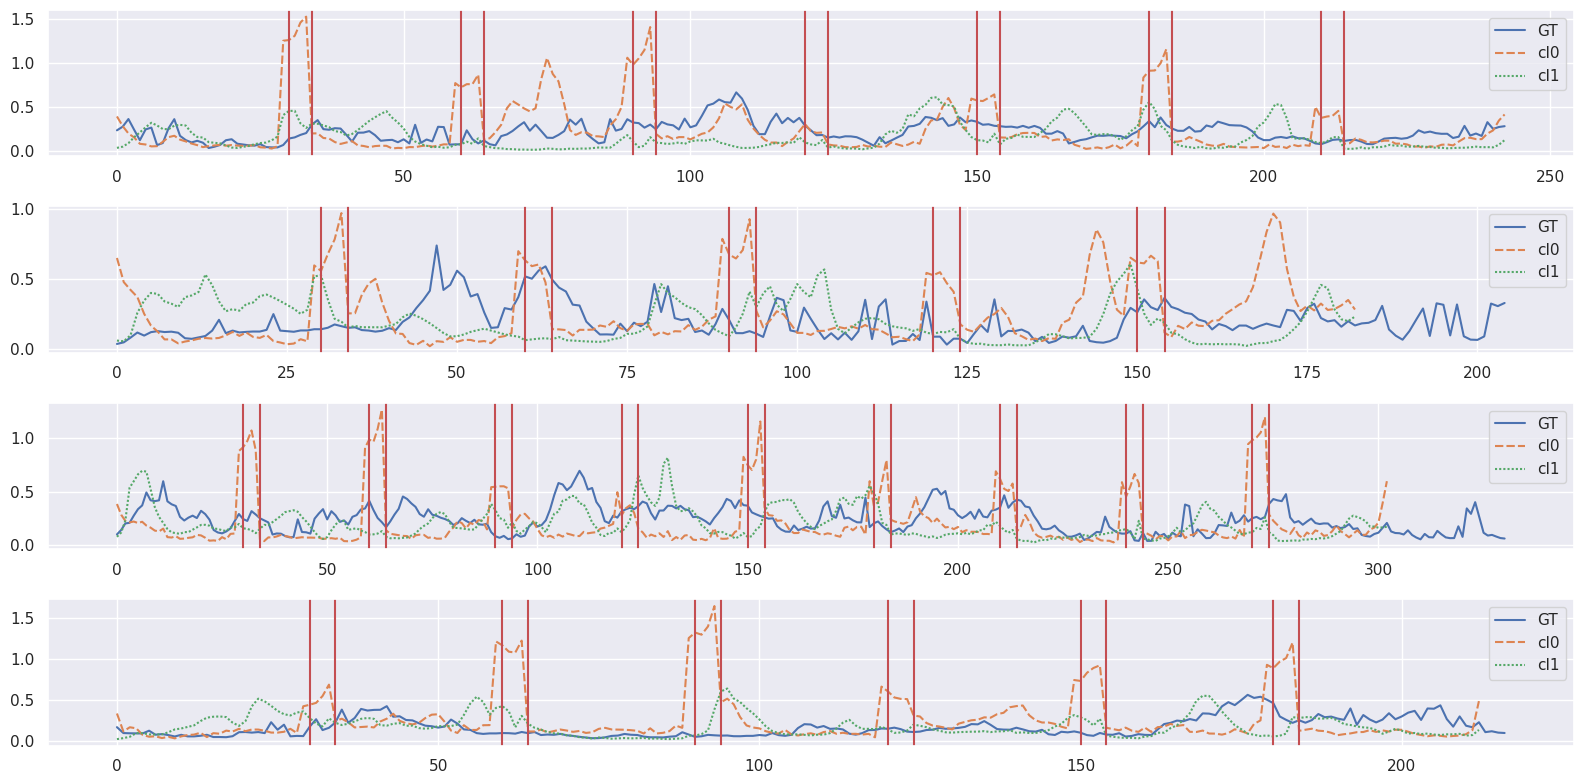

In [13]:
# Vel at all time steps for samples
# red is transition part
fig, axes = plt.subplots(4, 1, figsize=(16,8))

k = 0
motion_vel_seq = np.mean(motion_vel_list[k], axis=-1)
cl0_output_vel_seq = np.mean(cl0_output_vel_list[k], axis=-1)
cl1_output_vel_seq = np.mean(cl1_output_vel_list[k], axis=-1)
sns.lineplot(ax=axes[0], data={"GT": motion_vel_seq, "cl0": cl0_output_vel_seq, "cl1": cl1_output_vel_seq})
for i in range(1, len(cl0_output_vel_seq)//30):
    axes[0].axvline(30*i, c='r')
    axes[0].axvline(30*i+4, c='r')

k = 1
motion_vel_seq = np.mean(motion_vel_list[k], axis=-1)
cl0_output_vel_seq = np.mean(cl0_output_vel_list[k], axis=-1)
cl1_output_vel_seq = np.mean(cl1_output_vel_list[k], axis=-1)
sns.lineplot(ax=axes[1], data={"GT": motion_vel_seq, "cl0": cl0_output_vel_seq, "cl1": cl1_output_vel_seq})
for i in range(1, len(cl0_output_vel_seq)//30):
    axes[1].axvline(30*i, c='r')
    axes[1].axvline(30*i+4, c='r')

k = 4
motion_vel_seq = np.mean(motion_vel_list[k], axis=-1)
cl0_output_vel_seq = np.mean(cl0_output_vel_list[k], axis=-1)
cl1_output_vel_seq = np.mean(cl1_output_vel_list[k], axis=-1)
sns.lineplot(ax=axes[2], data={"GT": motion_vel_seq, "cl0": cl0_output_vel_seq, "cl1": cl1_output_vel_seq})
for i in range(1, len(cl0_output_vel_seq)//30):
    axes[2].axvline(30*i, c='r')
    axes[2].axvline(30*i+4, c='r')

k = 7
motion_vel_seq = np.mean(motion_vel_list[k], axis=-1)
cl0_output_vel_seq = np.mean(cl0_output_vel_list[k], axis=-1)
cl1_output_vel_seq = np.mean(cl1_output_vel_list[k], axis=-1)
sns.lineplot(ax=axes[3], data={"GT": motion_vel_seq, "cl0": cl0_output_vel_seq, "cl1": cl1_output_vel_seq})
for i in range(1, len(cl0_output_vel_seq)//30):
    axes[3].axvline(30*i, c='r')
    axes[3].axvline(30*i+4, c='r')

plt.tight_layout()
plt.show()